In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import itertools
from IPython.core.display import HTML
#import swifter

In [2]:
df_lyrics = pd.read_csv("data/lyrics.csv", sep =';')

df_lyrics[:5]

,ALink,SName,SLink,Lyric,ParentGenre,Genres,Genres_API
0,/andre-drake/,Bae ft. V.P Rap,/andre-drake/bae-ft-v-p-rap.html,[André Drake]. Minha princesa eu troco tudo pr...,Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
1,/andre-drake/,By Chance (Brazilian Remix),/andre-drake/by-chance-brazilian-remix.html,"[Refrão]. Mais views, pode ser?. Cê sabe, que ...",Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
2,/andre-drake/,Casa do Terror,/andre-drake/casa-do-terror.html,"4 Paredes uma jaula, na minha mão uma faca. Um...",Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
3,/andre-drake/,Na Madrugada,/andre-drake/na-madrugada.html,"[Refrão 1]. Na ""madruga"" não consigo dormir. m...",Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
4,/andre-drake/,V.P Convida Parte 2,/andre-drake/v-p-convida-parte-2.html,[Vp Rap]. Vp de novo que convida. Dessa vez se...,Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"


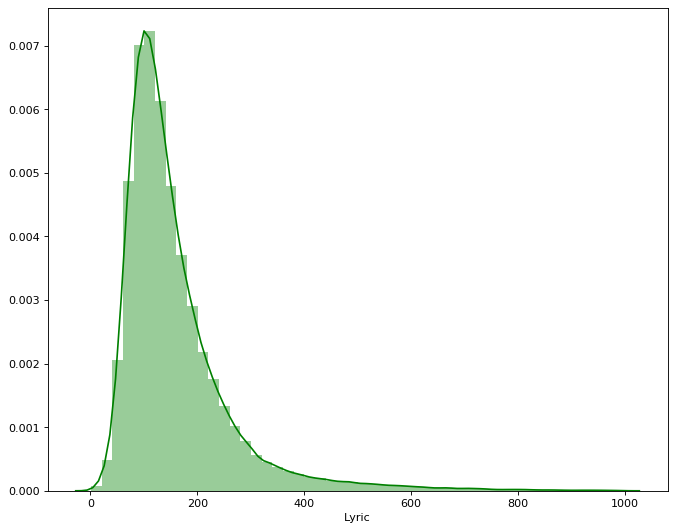

In [3]:
# Distribuição do número de palavras ao longo do dataset

len_serie = df_lyrics["Lyric"].str.split(' ').map(lambda x: len(x))
fig=plt.figure(figsize=(10, 8), dpi= 80)
sns.distplot(len_serie[len_serie<1000], color="g")

In [4]:
# Utilizar os gêneros trazidos pela API distorce muito o resultado, pois são demasiadamente numerosos.
# Utilizar apenas os 3 principais produziu uma visualização final melhor.

use_API = False
column_Genres = "Genres"
if(use_API):
    column_Genres = "Genres_API"

serie_genres_b = df_lyrics[column_Genres].value_counts()
df_genres = pd.DataFrame({"Genres":serie_genres_b.index, "Count": serie_genres_b}).reset_index(drop=True)

df_genres["Genres"] = df_genres["Genres"].str.split(', ')

# Dataframe construído para facilitar o cálculo das visões de correlação.
df_genres[0:5]

,Genres,Count
0,"[Sertanejo, Romântico, Country]",3822
1,[Gospel/Religioso],3564
2,"[Romântico, Sertanejo, Country]",1895
3,[Sertanejo],1723
4,"[Sertanejo, Romântico, Forró]",1708


In [5]:
genres = {}
for i in df_genres.index:
    genres_arr = df_genres["Genres"][i]
    for genre in genres_arr:
        genres[genre] = ''
genres = np.sort(list(genres.keys()))
# Todos os gêneros
genres

array(['Axé', 'Black Music', 'Blues', 'Bossa Nova', 'Chillout',
       'Classic Rock', 'Clássico', 'Country', 'Dance', 'Disco',
       'Electro Swing', 'Electronica', 'Emocore', 'Fado', 'Folk', 'Forró',
       'Funk', 'Funk Carioca', 'Gospel/Religioso', 'Grunge', 'Gótico',
       'Hard Rock', 'Hardcore', 'Heavy Metal', 'Hip Hop', 'House',
       'Indie', 'Industrial', 'Infantil', 'Instrumental', 'J-Pop/J-Rock',
       'Jazz', 'Jovem Guarda', 'K-Pop/K-Rock', 'Kizomba', 'MPB', 'Metal',
       'Músicas Gaúchas', 'New Age', 'New Wave', 'Pagode', 'Piano Rock',
       'Pop', 'Pop/Punk', 'Pop/Rock', 'Post-Rock', 'Power-Pop',
       'Progressivo', 'Psicodelia', 'Punk Rock', 'Pós-Punk', 'R&B', 'Rap',
       'Reggae', 'Reggaeton', 'Regional', 'Rock', 'Rock Alternativo',
       'Rockabilly', 'Romântico', 'Samba', 'Samba Enredo', 'Sertanejo',
       'Ska', 'Soft Rock', 'Soul Music', 'Surf Music', 'Tecnopop',
       'Trance', 'Trilha Sonora', 'Trip-Hop', 'Tropical House',
       'Velha Guarda', 'Wo

In [6]:
df_lyrics["SizeGenres"] = df_lyrics["Genres"].str.split(',').map(lambda x: len(x))
df_lyrics["SizeGenres"].value_counts()

3    137134
1     10417
2     10361
Name: SizeGenres, dtype: int64

In [7]:
# Distribuição das músicas cujos artistas possuem apenas 1 gênero listado
df_2 = df_lyrics[df_lyrics["SizeGenres"]==1]
df_2["ParentGenre"].value_counts()

Gospel/Religioso    3564
Sertanejo           1723
Romântico            940
MPB                  514
Funk Carioca         404
Rap                  394
Forró                384
Pop/Rock             337
Rock                 285
Pop                  258
Reggae               208
Samba                203
World Music          142
Rock Alternativo     113
Pagode               112
Samba Enredo         109
Bossa Nova           101
Infantil              81
Hip Hop               75
Punk Rock             71
Heavy Metal           63
Folk                  56
Hardcore              39
Trilha Sonora         38
Indie                 31
Fado                  23
Regional              22
Hard Rock             18
Kizomba               15
Blues                 15
Dance                 11
Electronica           10
Country               10
Metal                  9
Black Music            9
Funk                   6
R&B                    5
New Age                5
Jovem Guarda           3
J-Pop/J-Rock           3


In [8]:
df_total = pd.DataFrame(columns=genres, index =genres).fillna(0)
df_and = pd.DataFrame(columns=genres, index =genres).fillna(0)

# Produzindo visão de mapa de correlação (nova!)
# Cada quadrado do mapa representa a proporção de músicas de um gênero pai nas quais também aparece o gênero filho.
# Esta visão não produz uma matriz simétrica. E também produz um mapa de calor muito maior que o anterior.
# Tornando a visualização inviável. Logo, foi escolhido exibir o resultado em uma tabela (última célula).

def process(linha):
 
    genres_arr = linha['Genres']
    count      = linha['Count']
    
    global df_total
    global df_and
    
    for genre in genres_arr:
        
        df_total[genre] += count
        df_and[genre][genre] += count
        
    for subset in itertools.combinations(genres_arr, 2):
        df_and[subset[0]][subset[1]] += count
        df_and[subset[1]][subset[0]] += count
    
start = time.time()    
df_genres.apply(lambda linha: process(linha), axis =1)
end = time.time()

df_corr = df_and/df_total

print('\nTime(s): '+str("%.2f" % (end - start)+'s\n'))


Time(s): 3.09s



In [9]:
df_corr = df_corr.round(3)
df_corr

,Axé,Black Music,Blues,Bossa Nova,Chillout,Classic Rock,Clássico,Country,Dance,Disco,...,Soft Rock,Soul Music,Surf Music,Tecnopop,Trance,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
Axé,1.000,0.068,0.107,0.022,0.464,0.000,0.119,0.055,0.117,0.339,...,0.00,0.005,0.001,0.113,0.00,0.034,0.000,0.0,0.041,0.000
Black Music,0.017,1.000,0.066,0.000,0.000,0.000,0.000,0.023,0.002,0.000,...,0.00,0.245,0.000,0.000,0.00,0.003,0.133,0.0,0.000,0.009
Blues,0.011,0.028,1.000,0.023,0.000,0.078,0.019,0.005,0.001,0.000,...,0.02,0.011,0.000,0.000,0.00,0.035,0.000,0.0,0.031,0.001
Bossa Nova,0.008,0.000,0.083,1.000,0.272,0.000,0.031,0.000,0.000,0.000,...,0.00,0.051,0.000,0.000,0.00,0.010,0.000,0.0,0.112,0.049
Chillout,0.009,0.000,0.000,0.014,1.000,0.000,0.000,0.000,0.002,0.000,...,0.00,0.000,0.000,0.000,0.00,0.000,0.067,0.0,0.000,0.000
Classic Rock,0.000,0.000,0.008,0.000,0.000,1.000,0.000,0.001,0.000,0.000,...,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000
Clássico,0.064,0.000,0.100,0.044,0.000,0.000,1.000,0.003,0.021,0.061,...,0.00,0.040,0.000,0.000,0.00,0.079,0.000,0.0,0.067,0.083
Country,0.031,0.051,0.028,0.000,0.000,0.065,0.003,1.000,0.003,0.000,...,0.00,0.000,0.000,0.000,0.00,0.004,0.000,0.0,0.003,0.001
Dance,0.023,0.002,0.003,0.000,0.023,0.000,0.008,0.001,1.000,0.000,...,0.00,0.000,0.000,0.225,0.00,0.036,0.000,0.0,0.000,0.000
Disco,0.038,0.000,0.000,0.000,0.000,0.000,0.013,0.000,0.000,1.000,...,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.0,0.026,0.000


In [23]:
father_genre_list = []
son_genre_list = []
corr_list = []
num_msc_father_genre = []
num_msc_son_genre = []

for i in df_corr.columns:
    for j in df_corr.columns:
        if(i!=j):
            father_genre_list.append(i)
            son_genre_list.append(j)
            corr_list.append(df_corr[i][j])
            
            num_msc_father_genre.append(df_total[0:1][i].values[0])
            num_msc_son_genre.append(df_total[0:1][j].values[0])
                
df_corr_genres = pd.DataFrame({"Gênero Pai":father_genre_list, "Gênero Filho":son_genre_list, \
                               "Número de Músicas Pai": num_msc_father_genre, \
                               "Número de Músicas Filho": num_msc_son_genre,\
                               "Correlação": corr_list  })
df_corr_genres = df_corr_genres.sort_values(by="Correlação", ascending  = False)
df_corr_genres = df_corr_genres.reset_index(drop=True)

In [24]:
# Distribuição de gênero principal entre todas as músicas listadas
serie_parent_genre = df_lyrics["ParentGenre"].value_counts()

# Gêneros selecionados com critério simples: todos que possuem mais de 3000 instâncias
generos_selecionados = list(serie_parent_genre[serie_parent_genre >3000].index)
generos_selecionados

['Gospel/Religioso',
 'Sertanejo',
 'MPB',
 'Romântico',
 'Forró',
 'Samba',
 'Pop/Rock',
 'Rock',
 'Funk Carioca',
 'Pagode',
 'Rap',
 'Pop']

In [27]:
exibir_dataframe = lambda dataframe: display(HTML(dataframe.to_html()))

colunas_interesse = generos_selecionados + ["Regional","Country","Bossa Nova", "Rock Alternativo","Hip Hop"]
colunas_interesse.sort()

exibir_dataframe(df_corr_genres[(df_corr_genres["Gênero Pai"].isin(colunas_interesse)) &\
               (df_corr_genres["Gênero Filho"].isin(colunas_interesse)) &\
               (df_corr_genres['Correlação']>0.1)]) #generos_selecionados

,Gênero Pai,Gênero Filho,Número de Músicas Pai,Número de Músicas Filho,Correlação
7,Country,Sertanejo,11221,37398,0.946
20,Rock Alternativo,Rock,3684,14280,0.767
24,Hip Hop,Rap,7862,8341,0.756
26,Bossa Nova,MPB,7670,33427,0.747
27,Pagode,Samba,12104,18907,0.737
29,Rap,Hip Hop,8341,7862,0.713
43,Country,Romântico,11221,62638,0.611
51,Regional,Sertanejo,6439,37398,0.567
55,Sertanejo,Romântico,37398,62638,0.525
57,Pagode,Romântico,12104,62638,0.513


In [13]:
'''
Critérios de seleção
 
 - Unir Pagode a Samba
 - Unir Regional, Sertanejo, Forró e Country
 - Remover Romântico
 - Unir Rock, Pop/Rock e Rock Alternativo
 - Unir Rap e Hip-Hop
 - Unir Bossa Nova e MPB

'''

'\nCritérios de seleção\n \n - Unir Pagode a Samba\n - Unir Regional, Sertanejo, Forró e Country\n - Remover Romântico\n - Unir Rock, Pop/Rock e Rock Alternativo\n - Unir Rap e Hip-Hop\n - Unir Bossa Nova e MPB\n\n'

In [28]:

df = df_corr[colunas_interesse].loc[colunas_interesse]

def process_linha(linha):
    max_value = 0
    for key in linha.keys():
        if(linha[key]<1.0 and linha[key]> max_value):
            max_value = linha[key]
    return max_value>0.2
            

df = df[df.apply(process_linha, axis = 1)]

df

,Bossa Nova,Country,Forró,Funk Carioca,Gospel/Religioso,Hip Hop,MPB,Pagode,Pop,Pop/Rock,Rap,Regional,Rock,Rock Alternativo,Romântico,Samba,Sertanejo
Country,0.000,1.000,0.085,0.000,0.025,0.006,0.000,0.000,0.020,0.002,0.000,0.000,0.005,0.000,0.109,0.000,0.284
Forró,0.045,0.155,1.000,0.030,0.027,0.048,0.109,0.031,0.042,0.003,0.000,0.341,0.003,0.000,0.135,0.017,0.241
Gospel/Religioso,0.075,0.087,0.050,0.033,1.000,0.111,0.045,0.023,0.245,0.230,0.061,0.066,0.109,0.087,0.180,0.011,0.112
Hip Hop,0.000,0.004,0.018,0.092,0.023,1.000,0.008,0.012,0.014,0.008,0.713,0.000,0.007,0.002,0.020,0.009,0.001
MPB,0.747,0.001,0.179,0.014,0.040,0.033,1.000,0.065,0.224,0.180,0.034,0.194,0.140,0.062,0.228,0.387,0.055
Pagode,0.040,0.000,0.018,0.089,0.007,0.019,0.024,1.000,0.011,0.004,0.004,0.062,0.004,0.000,0.099,0.472,0.021
Pop,0.038,0.029,0.033,0.124,0.102,0.028,0.107,0.014,1.000,0.232,0.022,0.033,0.111,0.014,0.111,0.007,0.025
Pop/Rock,0.003,0.003,0.002,0.000,0.084,0.013,0.076,0.004,0.205,1.000,0.032,0.003,0.495,0.391,0.050,0.000,0.009
Rap,0.000,0.000,0.000,0.173,0.013,0.756,0.008,0.003,0.012,0.019,1.000,0.000,0.028,0.010,0.017,0.006,0.000
Rock,0.001,0.007,0.002,0.003,0.041,0.012,0.060,0.005,0.099,0.502,0.048,0.015,1.000,0.767,0.021,0.003,0.001


In [30]:
# rotacionando df

df_rot = pd.DataFrame(df.values.T, columns = df.index, index = df.columns)

def process_linha(linha):
    max_value = 0
    for key in linha.keys():
        if(linha[key]<1.0 and linha[key]> max_value):
            max_value = linha[key]
    return max_value>0.2

df_rot = df_rot[df_rot.apply(process_linha, axis = 1)]

df_rot

,Country,Forró,Gospel/Religioso,Hip Hop,MPB,Pagode,Pop,Pop/Rock,Rap,Rock,Romântico,Samba,Sertanejo
Bossa Nova,0.000,0.045,0.075,0.000,0.747,0.040,0.038,0.003,0.000,0.001,0.181,0.397,0.009
Country,1.000,0.155,0.087,0.004,0.001,0.000,0.029,0.003,0.000,0.007,0.611,0.000,0.946
Forró,0.085,1.000,0.050,0.018,0.179,0.018,0.033,0.002,0.000,0.002,0.412,0.015,0.439
Funk Carioca,0.000,0.030,0.033,0.092,0.014,0.089,0.124,0.000,0.173,0.003,0.163,0.007,0.249
Gospel/Religioso,0.025,0.027,1.000,0.023,0.040,0.007,0.102,0.084,0.013,0.041,0.295,0.006,0.109
Hip Hop,0.006,0.048,0.111,1.000,0.033,0.019,0.028,0.013,0.756,0.012,0.159,0.022,0.006
MPB,0.000,0.109,0.045,0.008,1.000,0.024,0.107,0.076,0.008,0.060,0.428,0.219,0.061
Pagode,0.000,0.031,0.023,0.012,0.065,1.000,0.014,0.004,0.003,0.005,0.513,0.737,0.066
Pop,0.020,0.042,0.245,0.014,0.224,0.011,1.000,0.205,0.012,0.099,0.433,0.008,0.060
Pop/Rock,0.002,0.003,0.230,0.008,0.180,0.004,0.232,1.000,0.019,0.502,0.224,0.000,0.023


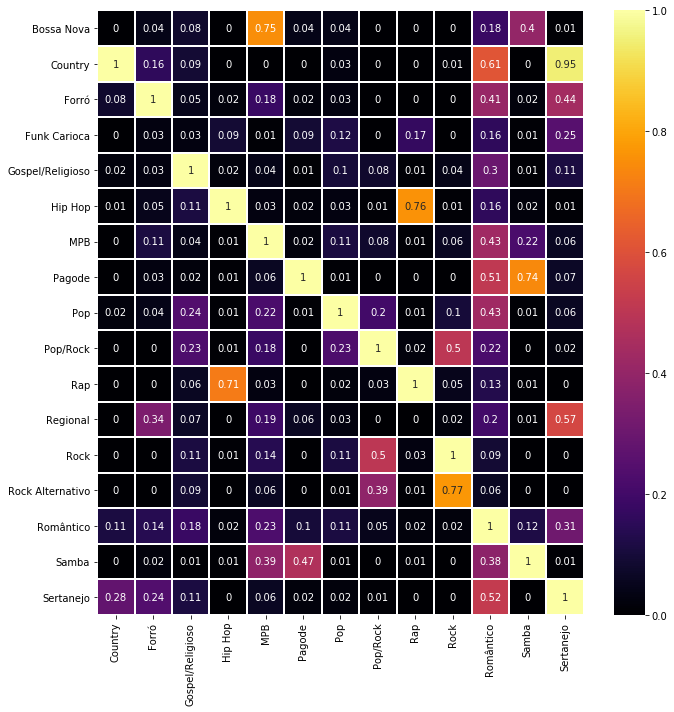

In [33]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_rot.round(2), cmap = 'inferno', annot=True, linewidth = 1)

plt.show()